In [ ]:
#First run this code to upload your file
from google.colab import files

uploaded = files.upload()

Saving Data_2020-2022_wExpiry.csv to Data_2020-2022_wExpiry.csv


Start                     2020-01-01 09:20:00
End                       2022-12-30 15:30:00
Duration                   1094 days 06:10:00
Exposure Time [%]                   90.547811
Equity Final [$]              14234264.482143
Equity Peak [$]               14237604.048143
Return [%]                         306.693271
Buy & Hold Return [%]              -24.906523
Return (Ann.) [%]                   61.138794
Volatility (Ann.) [%]               27.706056
Sharpe Ratio                         2.206694
Sortino Ratio                        9.119413
Calmar Ratio                          6.01309
Max. Drawdown [%]                  -10.167617
Avg. Drawdown [%]                   -0.328494
Max. Drawdown Duration       97 days 23:25:00
Avg. Drawdown Duration        1 days 08:30:00
# Trades                                 7701
Win Rate [%]                        40.864823
Best Trade [%]                      12.790478
Worst Trade [%]                     -1.588426
Avg. Trade [%]                    

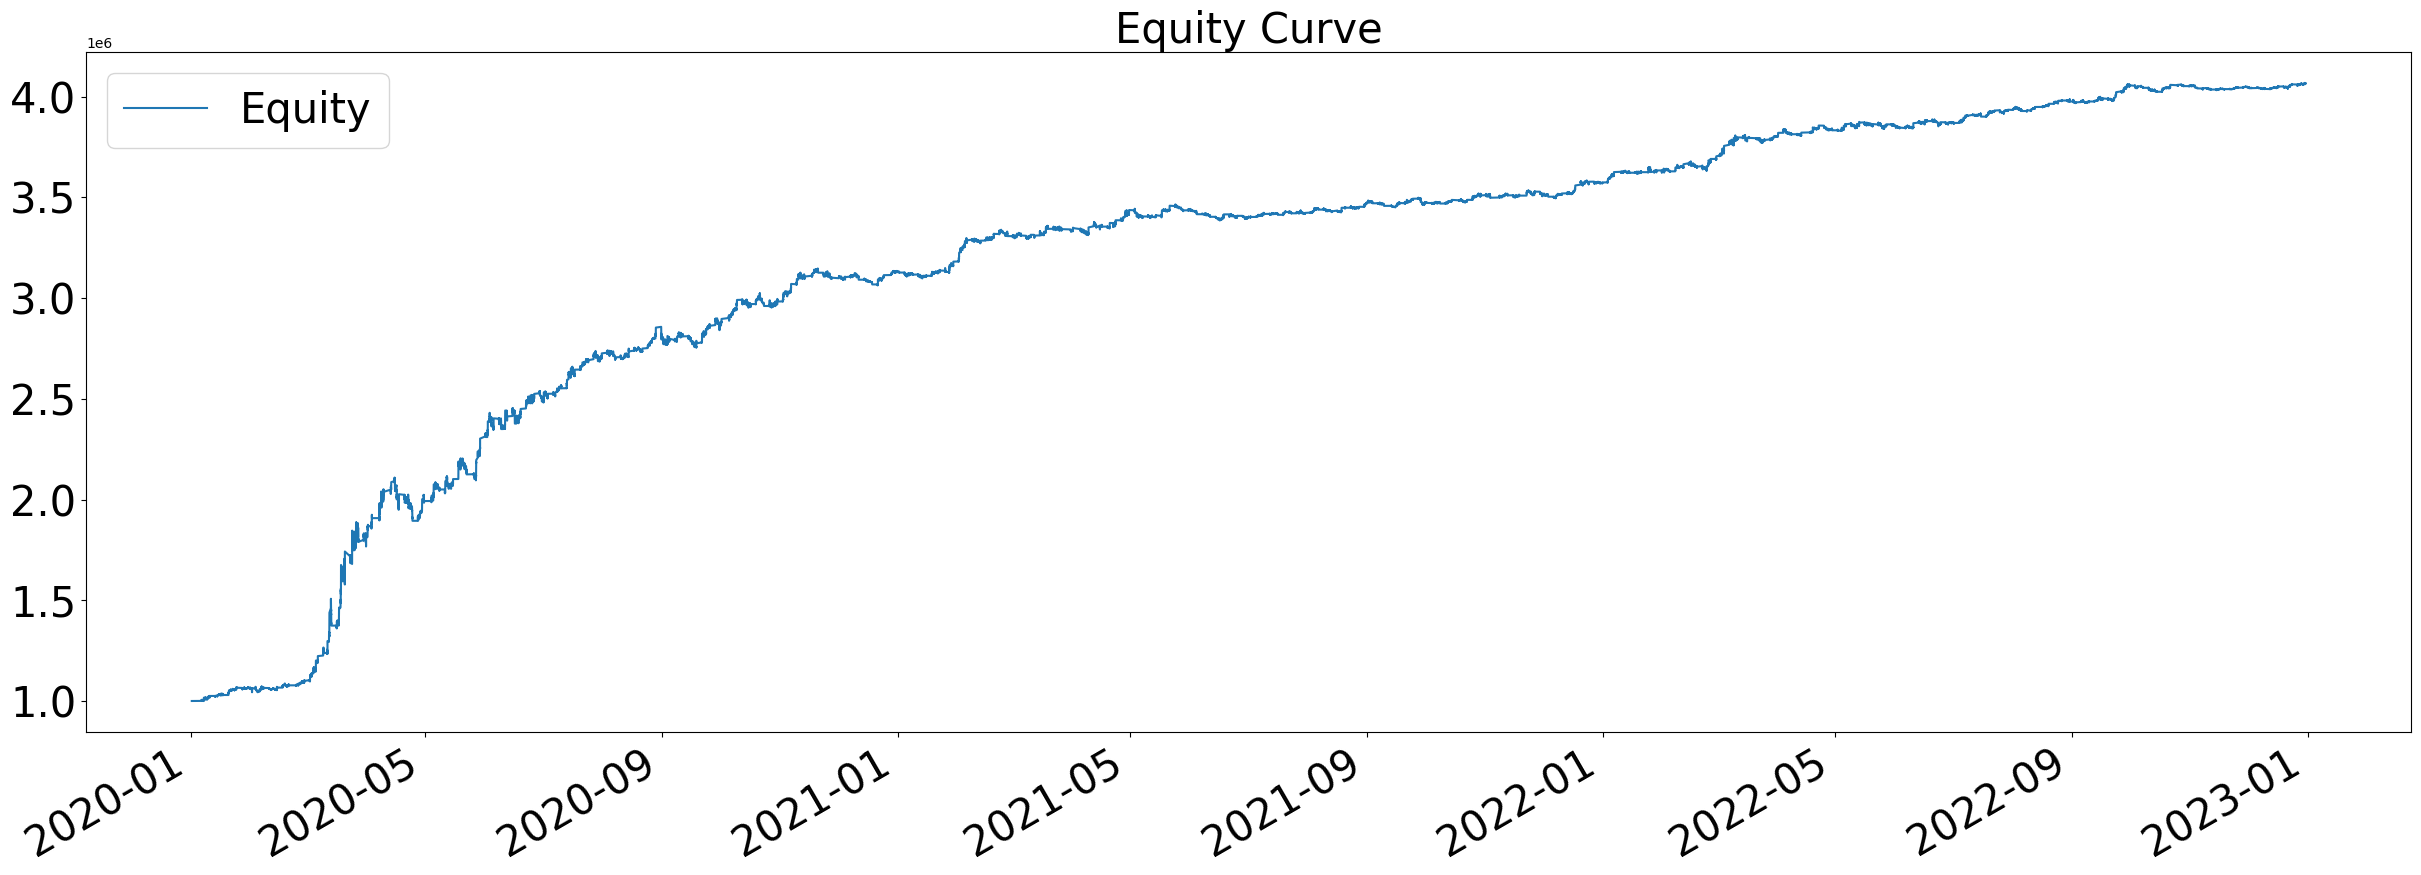

Trade Sheet:


,Qty,EntryTime,EntryPrice,ExitTime,ExitPrice,Duration,PnL,ReturnPct
0,100,2020-01-06 10:35:00,31601.91697,2020-01-06 11:55:00,31740.465300,0 days 01:20:00,13854.833000,0.004384
1,100,2020-01-06 11:55:00,31756.56686,2020-01-06 12:25:00,31751.400677,0 days 00:30:00,-516.618286,-0.000163
2,100,2020-01-06 12:25:00,31749.96269,2020-01-06 13:05:00,31776.019957,0 days 00:40:00,2605.726714,0.000821
3,100,2020-01-06 13:05:00,31772.60979,2020-01-06 13:45:00,31752.041611,0 days 00:40:00,-2056.817857,-0.000647
4,100,2020-01-06 13:50:00,31770.28811,2020-01-06 14:10:00,31804.487823,0 days 00:20:00,3419.971286,0.001076
...,...,...,...,...,...,...,...,...
7696,-100,2022-12-30 13:20:00,23100.79686,2022-12-30 13:45:00,23115.987138,0 days 00:25:00,-1519.027786,-0.000658
7697,-100,2022-12-30 13:45:00,23115.10746,2022-12-30 13:55:00,23135.304783,0 days 00:10:00,-2019.732286,-0.000874
7698,-100,2022-12-30 13:55:00,23134.75998,2022-12-30 14:25:00,23102.169603,0 days 00:30:00,3259.037714,0.001409
7699,-100,2022-12-30 14:30:00,23115.50819,2022-12-30 15:00:00,23074.544607,0 days 00:30:00,4096.358286,0.001772


In [ ]:
#Replace the name inside file with the above filename (Please opt for csv file format only)
file='/content/Data_2020-2022_wExpiry.csv'

# Importing and  necessary Libraries
!pip install backtesting
from backtesting import Backtest, Strategy
from backtesting.test import SMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


# Function to read data from a CSV file and preprocess it
def read_data(file_name):
    """
    Read data from a CSV file, preprocess it, and return a DataFrame.

    Parameters:
    - file_name (str): Path to the CSV file.

    Returns:
    - pd.DataFrame: Processed data with DateTime as the index.
    """
    data=pd.read_csv(file_name, sep=',', header=None,
                   names=['Date_Start', 'Date_End', 'Time', 'Open', 'High', 'Low', 'Close'])
    data['DateTime'] = pd.to_datetime(data['Date_Start'].astype(str) + data['Time'].astype(str).str.zfill(4), format='%Y%m%d%H%M')
    data.drop(data.columns[[0,2]],axis=1,inplace=True)
    column_to_move = "DateTime"
    data = data.set_index(column_to_move)
    return data

# Function to get expiry dates from the data
def getExpiry(data):
    """
    Extract expiry dates from the data.

    Parameters:
    - data (pd.DataFrame): Processed data.

    Returns:
    - pd.Series: Expiry dates.
    """
    unique_dates = data['Date_End'].unique()
    unique_dates=list(unique_dates)
    return pd.to_datetime(unique_dates, format='%Y%m%d') + pd.Timedelta('15:30:00'),unique_dates

# Function to resample the data at a specified frequency
def resampling_data(data,frequency):
    """
    Resample data at a specified frequency and perform necessary adjustments.

    Parameters:
    - data (pd.DataFrame): Original data.
    - resample_size (str): Resampling frequency.

    Returns:
    - pd.DataFrame: Resampled data.
    """
    new_row_datetime = pd.to_datetime("2020-01-01 09:15:00")
    new_row = pd.DataFrame(index=[new_row_datetime], columns=data.columns)
    data = pd.concat([data, new_row])
    data = data.sort_index()
    data = data.shift(-1)
    data.drop(columns=['Date_End'], axis=1, inplace=True)
    data = data.resample(frequency, label='right').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})
    data.dropna(inplace=True)
    return data

# Class for a custom trailing strategy
class TrailingStrategy(Strategy):
    """
    Custom trailing strategy class derived from the backtesting library's Strategy class to calculate
    stop loss using ATR Indicator for trailing stop loss.
    The stop loss is dynamically set at the initial stop loss value (StopLossInitial) from the current price.
    The strategy includes an expiration condition to prevent new buy or sell orders when the current timestamp is in timestamp_array.
    """
    _n_atr = 6.
    _atr = None

    def init(self):
        super().init()
        self.set_atr_periods()

    def set_atr_periods(self, periods: int = 14):
        """
        ATR Indicator
        """
        hi, lo, c_prev = self.data.High, self.data.Low, pd.Series(self.data.Close).shift(1)
        tr = np.max([hi - lo, (c_prev - hi).abs(), (c_prev - lo).abs()], axis=0)
        atr = pd.Series(tr).rolling(periods).mean().bfill().values
        self._atr = atr

    def set_trailing_sl(self, n_atr: float = 6):
        """
        Function to set ATR trailing multiplier, to be used in main Strategy class
        """
        self._n_atr = n_atr

    def next(self):
        super().next()
        index = len(self.data)-1
        for trade in self.trades:
            if trade.is_long:
                trade.sl = max(trade.sl or -np.inf,
                               self.data.Close[index] - self._atr[index] * self._n_atr)
            else:
                trade.sl = min(trade.sl or np.inf,
                               self.data.Close[index] + self._atr[index] * self._n_atr)

# Class for a custom strategy derived from the trailing strategy
class AlgameHFT_Strategy(TrailingStrategy):
    """
    Custom strategy class derived from the TrailingStrategy class.
    This High-Frequency Trading (HFT) strategy is based on the relationship between two
    moving averages: a shorter-term moving average (ma2) and a longer-term moving average (ma1).
    """
    i_ma1 = 240
    i_ma2 = 5
    StopLossInitial =400
    stopLossATR=1

    quantity=100

    def init(self):
        super().init()
        super().set_trailing_sl(self.stopLossATR)

        self.ma1 = self.I(SMA, self.data.Close, self.i_ma1)
        self.ma2 = self.I(SMA, self.data.Close, self.i_ma2)

    def next(self):
        super().next()

        price = self.data.Close[-1]

        expiryCondition = (self.data.index[-1] in timestamp_array)
        """Long (Buy) Conditions:
            Signal: A potential uptrend is identified when the shorter-term moving average (ma2) crosses above the longer-term moving average (ma1).
            Trade Entry: Buy when the current close is below ma2 (indicating a retracement) and there is no existing position.
            Take Profit: Close the long position when the price closes above ma2 and below the low of the previous candle.
            """
        buyCondition1 = (self.data.Close[-1] > self.ma1[-1]) and (self.data.Close[-1] < self.ma2[-1]) and (not self.position)
        buyclose = (self.ma2[-1]<self.data.Close[-1]) and (self.position) and (self.data.Close[-1] < self.data.Low[-2])

        """
        Short (Sell) Conditions:
        Signal: A potential downtrend is identified when the shorter-term moving average (ma2) crosses below the longer-term moving average (ma1).
        Trade Entry: Sell when the current close is above ma2 (indicating a retracement) and there is no existing position.
        Take Profit: Close the short position when the price closes below ma2 and above the high of the previous candle.
        """
        sellCondition1 = (self.data.Close[-1] < self.ma1[-1]) and (self.data.Close[-1] > self.ma2[-1]) and (not self.position)
        sellclose = (self.ma2[-1]>self.data.Close[-1]) and (self.position) and (self.data.Close[-1] > self.data.High[-2])



        if buyCondition1  and not expiryCondition :
            self.buy(size = self.quantity,sl=price-self.StopLossInitial)

        elif sellCondition1  and not expiryCondition :
            self.sell(size = self.quantity,sl=price+self.StopLossInitial)

        if (buyclose and self.position.is_long) or expiryCondition:
            self.position.close()

        elif (sellclose and self.position.is_long) or expiryCondition:
            self.position.close()

# Function to run the strategy on the provided data
def run_strategy(data,initial_equity,quantity,brokerage):
    """
    Run the custom strategy on the provided data.

    Parameters:
    - data (pd.DataFrame): Processed data.
    - initial_equity (float): Initial capital for backtesting.
    - quantity (int): Trading quantity.
    - brokerage (float): Transaction cost per trade.

    Returns:
    - list: List containing trade sheet, performance metrics, and equity curve.
    """
    bt = Backtest(data, AlgameHFT_Strategy, cash=initial_equity,  trade_on_close=True, exclusive_orders = True)
    stats =bt.run()
    bt.plot()
    print(stats)
    trade_sheet=stats['_trades']

    percentage_profitability=stats['Return [%]']
    gross_profit=(stats['Equity Final [$]']-initial_equity)
    net_profit=gross_profit-brokerage*quantity*stats['# Trades']
    max_drawdown=stats['Max. Drawdown [%]']
    annual_return=stats['Return (Ann.) [%]']
    calmar_ratio=stats['Calmar Ratio']
    equity=stats._equity_curve
    return [trade_sheet,percentage_profitability,gross_profit,net_profit,max_drawdown,annual_return,calmar_ratio,equity]

# Function to get the results of running the strategy
def get_result(data,initial_equity,quantity,brokerage):
    """
    Get the results of running the custom strategy.

    Parameters:
    - data (pd.DataFrame): Processed data.
    - initial_equity (float): Initial capital for backtesting.
    - quantity (int): Trading quantity.
    - brokerage (float): Transaction cost per trade.

    Returns:
    - list: List containing trade sheet, performance metrics, and equity curve.
    """
    result=run_strategy(data,initial_equity,quantity,brokerage)
    return result

# Function to generate the trade sheet and save it in a csv file
def generate_trade_sheet(result):
    """
    Generate and format the trade sheet and save it in a csv file.

    Parameters:
    - result (list): List containing trade sheet, performance metrics, and equity curve.

    """
    trade_sheet=result[0]
    trade_sheet.rename(columns={'Size':'Qty',},inplace=True)
    reorder=['Qty','EntryTime','EntryPrice','ExitTime','ExitPrice','Duration','PnL','ReturnPct']
    trade_sheet=trade_sheet[reorder]

    #Save the Trade Sheet
    trade_sheet.to_csv('Trade Sheet.csv')
    return trade_sheet

# Function to generate the equity curve
def get_equity_curve():
    """
    Plot and display the equity curve.

    Parameters:
    - result (list): List containing trade sheet, performance metrics, and equity curve.

    """
    equity=result[7]
    equity['Equity']=equity.Equity//3.5
    equity['Equity'].plot(figsize=(30,10),fontsize=30)
    plt.title("Equity Curve",fontsize=30)
    plt.legend(fontsize=30)
    plt.show()

def calculate_monthly_pnl(trade_sheet, date_array):
    """
    Calculate monthly P&L (Profit and Loss) percentages based on the provided trade sheet.

    Parameters:
    - trade_sheet (pd.DataFrame): DataFrame containing trade information including EntryTime, ExitTime, and ReturnPct columns.
    - date_array (list): List of date periods (in the format YYYYMM) for which monthly P&L needs to be calculated.

    Returns:
    - None
    """

    trade_sheet['EntryTime'] = pd.to_datetime(trade_sheet['EntryTime'])
    trade_sheet['ExitTime'] = pd.to_datetime(trade_sheet['ExitTime'])
    trade_sheet['Month'] = trade_sheet['EntryTime'].dt.to_period('M')

    monthly_pnl = {}

    for date in date_array:
        month_df = trade_sheet[trade_sheet['Month'] == str(date)]
        total_pnl_percent = round(month_df['ReturnPct'].sum()*100,3)
        year = int(str(date)[:4])
        month = int(str(date)[4:6])
        formatted_date = datetime(year, month, 1).strftime('%B %Y')
        monthly_pnl[formatted_date] = total_pnl_percent

    print("Monthly Returns:")
    for k,v in monthly_pnl.items():
        print(f"{k}=\t{v}%")

# Function to print performance metrics
def performance_report(result):
    """
    Print performance metrics from the strategy.

    Parameters:
    - result (list): List containing trade sheet, performance metrics, and equity curve.
    """
    print('Net Profit:',result[3])
    print('Max Drawdown:',round(result[4],3))
    print('Percentage Profitability:',result[1])
    print('Gross Profit:',result[2])
    print("Annual Return:",result[5])
    print('Calmar Ratio:',result[6])
    print()
    calculate_monthly_pnl(generate_trade_sheet(result),date_array)
    get_equity_curve()


#Given Parameters
quantity=100
brokerage=7.5
frequency='5T'
# Initial equity taken is 35,00,000 as average price of 1 quantity was 35,000 and we were asked to use 100 quantities per trade
initial_equity=3500000

#Calling user defined functions to run the backtest on the strategy
data=read_data(file)
timestamp_array,date_array=getExpiry(data)
data=resampling_data(data,frequency)
result=get_result(data,initial_equity,quantity,brokerage)
performance_report(result)
print("Trade Sheet:")

generate_trade_sheet(result)